In [1]:
] activate ../ 

In [2]:
using Revise
using POMDPs
using GridInterpolations 
using POMDPModelTools
using POMDPPolicies
using Parameters
using StaticArrays
using DiscreteValueIteration 
using Distributed
using AutomotiveDrivingModels
using AutoViz
using AutomotiveSensors
using AutomotivePOMDPs
using PedestrianAvoidancePOMDP

using FileIO
using JLD2

┌ Info: Recompiling stale cache file /home/markuss/.julia/compiled/v1.0/PedestrianAvoidancePOMDP/UuJ2S.ji for PedestrianAvoidancePOMDP [a80ff0fe-e6a0-11e8-3b05-15413bd5ea7a]
└ @ Base loading.jl:1190
┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
│ - If you have PedestrianAvoidancePOMDP checked out for development and have
│   added EmergencyBrakingSystem as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PedestrianAvoidancePOMDP
└ Loading EmergencyBrakingSystem into PedestrianAvoidancePOMDP from project dependency, future warnings for PedestrianAvoidancePOMDP are suppressed.


In [3]:
N_PROCS=56
addprocs(N_PROCS)
@everywhere begin 
    using POMDPs
    using GridInterpolations 
    using POMDPModelTools
    using POMDPPolicies
    using POMDPToolbox

    using Parameters
    using StaticArrays
    using DiscreteValueIteration 

    using AutomotiveDrivingModels
    using AutoViz
    using AutomotiveSensors
    using AutomotivePOMDPs
    using PedestrianAvoidancePOMDP

    pomdp = SingleOCFPOMDP()
end 


┌ Warning: Importing POMDPToolbox. As of Julia 0.7 POMDPToolbox has been discontinued. Please use POMDPModelTools, POMDPPolicies, BeliefUpdaters, and/or POMDPSimulators instead.
└ @ POMDPToolbox /home/markuss/.julia/packages/POMDPToolbox/OdZy7/src/POMDPToolbox.jl:4
┌ Warning: Importing POMDPToolbox. As of Julia 0.7 POMDPToolbox has been discontinued. Please use POMDPModelTools, POMDPPolicies, BeliefUpdaters, and/or POMDPSimulators instead.
└ @ POMDPToolbox ~/.julia/packages/POMDPToolbox/OdZy7/src/POMDPToolbox.jl:4
┌ Warning: Importing POMDPToolbox. As of Julia 0.7 POMDPToolbox has been discontinued. Please use POMDPModelTools, POMDPPolicies, BeliefUpdaters, and/or POMDPSimulators instead.
└ @ POMDPToolbox ~/.julia/packages/POMDPToolbox/OdZy7/src/POMDPToolbox.jl:4
┌ Warning: Importing POMDPToolbox. As of Julia 0.7 POMDPToolbox has been discontinued. Please use POMDPModelTools, POMDPPolicies, BeliefUpdaters, and/or POMDPSimulators instead.
└ @ POMDPToolbox ~/.julia/packages/POMDPToolbox/

┌ Warning: Importing POMDPToolbox. As of Julia 0.7 POMDPToolbox has been discontinued. Please use POMDPModelTools, POMDPPolicies, BeliefUpdaters, and/or POMDPSimulators instead.
└ @ POMDPToolbox ~/.julia/packages/POMDPToolbox/OdZy7/src/POMDPToolbox.jl:4
┌ Warning: Importing POMDPToolbox. As of Julia 0.7 POMDPToolbox has been discontinued. Please use POMDPModelTools, POMDPPolicies, BeliefUpdaters, and/or POMDPSimulators instead.
└ @ POMDPToolbox ~/.julia/packages/POMDPToolbox/OdZy7/src/POMDPToolbox.jl:4
┌ Warning: Importing POMDPToolbox. As of Julia 0.7 POMDPToolbox has been discontinued. Please use POMDPModelTools, POMDPPolicies, BeliefUpdaters, and/or POMDPSimulators instead.
└ @ POMDPToolbox ~/.julia/packages/POMDPToolbox/OdZy7/src/POMDPToolbox.jl:4
┌ Warning: Importing POMDPToolbox. As of Julia 0.7 POMDPToolbox has been discontinued. Please use POMDPModelTools, POMDPPolicies, BeliefUpdaters, and/or POMDPSimulators instead.
└ @ POMDPToolbox ~/.julia/packages/POMDPToolbox/OdZy7/src/PO

      From worker 54:	┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
      From worker 54:	│ - If you have PedestrianAvoidancePOMDP checked out for development and have
      From worker 54:	│   added EmergencyBrakingSystem as a dependency but haven't updated your primary
      From worker 54:	│   environment's manifest file, try `Pkg.resolve()`.
      From worker 54:	│ - Otherwise you may need to report an issue with PedestrianAvoidancePOMDP
      From worker 54:	└ Loading EmergencyBrakingSystem into PedestrianAvoidancePOMDP from project dependency, future warnings for PedestrianAvoidancePOMDP are suppressed.
      From worker 32:	┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
      From worker 32:	│ - If you have PedestrianAvoidancePOMDP checked out for development and have
      From worker 32:	│   added EmergencyBrakingSystem as a dependency but haven't updated your primary

      From worker 10:	┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
      From worker 10:	│ - If you have PedestrianAvoidancePOMDP checked out for development and have
      From worker 10:	│   added EmergencyBrakingSystem as a dependency but haven't updated your primary
      From worker 10:	│   environment's manifest file, try `Pkg.resolve()`.
      From worker 10:	│ - Otherwise you may need to report an issue with PedestrianAvoidancePOMDP
      From worker 10:	└ Loading EmergencyBrakingSystem into PedestrianAvoidancePOMDP from project dependency, future warnings for PedestrianAvoidancePOMDP are suppressed.
      From worker 49:	┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
      From worker 49:	│ - If you have PedestrianAvoidancePOMDP checked out for development and have
      From worker 49:	│   added EmergencyBrakingSystem as a dependency but haven't updated your primary

      From worker 37:	┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
      From worker 37:	│ - If you have PedestrianAvoidancePOMDP checked out for development and have
      From worker 37:	│   added EmergencyBrakingSystem as a dependency but haven't updated your primary
      From worker 37:	│   environment's manifest file, try `Pkg.resolve()`.
      From worker 37:	│ - Otherwise you may need to report an issue with PedestrianAvoidancePOMDP
      From worker 37:	└ Loading EmergencyBrakingSystem into PedestrianAvoidancePOMDP from project dependency, future warnings for PedestrianAvoidancePOMDP are suppressed.
      From worker 39:	┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
      From worker 39:	│ - If you have PedestrianAvoidancePOMDP checked out for development and have
      From worker 39:	│   added EmergencyBrakingSystem as a dependency but haven't updated your primary

      From worker 2:	┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
      From worker 2:	│ - If you have PedestrianAvoidancePOMDP checked out for development and have
      From worker 2:	│   added EmergencyBrakingSystem as a dependency but haven't updated your primary
      From worker 2:	│   environment's manifest file, try `Pkg.resolve()`.
      From worker 2:	│ - Otherwise you may need to report an issue with PedestrianAvoidancePOMDP
      From worker 2:	└ Loading EmergencyBrakingSystem into PedestrianAvoidancePOMDP from project dependency, future warnings for PedestrianAvoidancePOMDP are suppressed.
      From worker 4:	┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
      From worker 4:	│ - If you have PedestrianAvoidancePOMDP checked out for development and have
      From worker 4:	│   added EmergencyBrakingSystem as a dependency but haven't updated your primary
      Fr

      From worker 12:	WARNING: Method definition propagate(Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, AutomotiveDrivingModels.LatLonAccel, AutomotiveDrivingModels.Roadway, Float64) in module EmergencyBrakingSystem at /home/markuss/EmergencyBrakingSystem.jl/src/emergency_system.jl:144 overwritten in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/frenet_pedestrian_pomdp.jl:110.
      From worker 24:	WARNING: Method definition propagate(Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, AutomotiveDrivingModels.LatLonAccel, AutomotiveDrivingModels.Roadway, Float64) in module EmergencyBrakingSystem at /home/markuss/EmergencyBrakingSystem.jl/src/emergency_system.jl:144 overwritten in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/frenet_pedestrian_pomdp.jl:110.
      From worker 46:	WARNIN

      From worker 15:	WARNING: Method definition propagate(Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, AutomotiveDrivingModels.LatLonAccel, AutomotiveDrivingModels.Roadway, Float64) in module EmergencyBrakingSystem at /home/markuss/EmergencyBrakingSystem.jl/src/emergency_system.jl:144 overwritten in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/frenet_pedestrian_pomdp.jl:110.
      From worker 16:	WARNING: Method definition propagate(Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, AutomotiveDrivingModels.LatLonAccel, AutomotiveDrivingModels.Roadway, Float64) in module EmergencyBrakingSystem at /home/markuss/EmergencyBrakingSystem.jl/src/emergency_system.jl:144 overwritten in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/frenet_pedestrian_pomdp.jl:110.
      From worker 47:	WARNIN

      From worker 31:	WARNING: Method definition propagate(Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, AutomotiveDrivingModels.LatLonAccel, AutomotiveDrivingModels.Roadway, Float64) in module EmergencyBrakingSystem at /home/markuss/EmergencyBrakingSystem.jl/src/emergency_system.jl:144 overwritten in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/frenet_pedestrian_pomdp.jl:110.
      From worker 8:	WARNING: Method definition propagate(Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, AutomotiveDrivingModels.LatLonAccel, AutomotiveDrivingModels.Roadway, Float64) in module EmergencyBrakingSystem at /home/markuss/EmergencyBrakingSystem.jl/src/emergency_system.jl:144 overwritten in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/frenet_pedestrian_pomdp.jl:110.
      From worker 52:	WARNING

      From worker 9:	WARNING: Method definition propagate(Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, AutomotiveDrivingModels.LatLonAccel, AutomotiveDrivingModels.Roadway, Float64) in module EmergencyBrakingSystem at /home/markuss/EmergencyBrakingSystem.jl/src/emergency_system.jl:144 overwritten in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/frenet_pedestrian_pomdp.jl:110.
      From worker 32:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, PO

      From worker 51:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

      From worker 36:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

      From worker 3:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From 

      From worker 15:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

      From worker 37:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

      From worker 28:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

      From worker 56:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

      From worker 41:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PedestrianAvoidancePOMDP [a80ff0fe-e6a0-11e8-3b05-15413bd5ea7a]
│   exception = ArgumentError: Invalid checksum in cache file /home/markuss/.julia/compiled/v1.0/PedestrianAvoidancePOMDP/UuJ2S.ji.
└ @ Base loading.jl:969


      From worker 44:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PedestrianAvoidancePOMDP [a80ff0fe-e6a0-11e8-3b05-15413bd5ea7a]
│   exception = ArgumentError: Invalid checksum in cache file /home/markuss/.julia/compiled/v1.0/PedestrianAvoidancePOMDP/UuJ2S.ji.
└ @ Base loading.jl:969
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PedestrianAvoidancePOMDP [a80ff0fe-e6a0-11e8-3b05-15413bd5ea7a]
│   exception = ArgumentError: Invalid checksum in cache file /home/markuss/.julia/compiled/v1.0/PedestrianAvoidancePOMDP/UuJ2S.ji.
└ @ Base loading.jl:969


      From worker 45:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PedestrianAvoidancePOMDP [a80ff0fe-e6a0-11e8-3b05-15413bd5ea7a]
│   exception = ArgumentError: Invalid checksum in cache file /home/markuss/.julia/compiled/v1.0/PedestrianAvoidancePOMDP/UuJ2S.ji.
└ @ Base loading.jl:969


      From worker 11:	WARNING: Method definition animate_record(Records.QueueRecord{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}}, Float64, AutomotivePOMDPs.CrosswalkEnv, AutomotiveSensors.GaussianSensor{P, V} where V<:AutomotiveSensors.AbstractNoiseModel where P<:AutomotiveSensors.AbstractNoiseModel, Array{Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, 1}, Array{Float64, 1}, Array{Base.Dict{Int64, POMDPModelTools.SparseCat{Array{PedestrianAvoidancePOMDP.SingleOCFState, 1}, Array{Float64, 1}}}, 1}, Array{Records.Entity{AutomotiveDrivingModels.VehicleState, AutomotiveDrivingModels.VehicleDef, Int64}, 1}, Array{PedestrianAvoidancePOMDP.SingleOCFAction, 1}) in module PedestrianAvoidancePOMDP at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:33 overwritten at /home/markuss/.julia/packages/PedestrianAvoidancePOMDP/xWTEk/src/rendering.jl:61.
      From

┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PedestrianAvoidancePOMDP [a80ff0fe-e6a0-11e8-3b05-15413bd5ea7a]
│   exception = ArgumentError: Invalid checksum in cache file /home/markuss/.julia/compiled/v1.0/PedestrianAvoidancePOMDP/UuJ2S.ji.
└ @ Base loading.jl:969
┌ Warning: Package PedestrianAvoidancePOMDP does not have EmergencyBrakingSystem in its dependencies:
│ - If you have PedestrianAvoidancePOMDP checked out for development and have
│   added EmergencyBrakingSystem as a dependency but haven't updated your primary
│   environment's manifest file, try `Pkg.resolve()`.
│ - Otherwise you may need to report an issue with PedestrianAvoidancePOMDP
└ Loading EmergencyBrakingSystem into PedestrianAvoidancePOMDP from project dependency, future warnings for PedestrianAvoidancePOMDP are suppressed.
┌ Warning: The call to compilecache failed to create a usable precompiled cache file for PedestrianAvoidancePOMDP [a80ff0fe-e6a0-11e8-3b05-15413bd5ea7

In [4]:
pomdp = SingleOCFPOMDP()
solver = ParallelValueIterationSolver(n_procs=N_PROCS, max_iterations=80, belres=1e-4, include_Q=true, verbose=true)


ParallelValueIterationSolver(80, 0.0001, true, true, Float64[], true, 56)

In [5]:
vi_policy = solve(solver, pomdp)
qmdp_policy = AlphaVectorPolicy(pomdp, vi_policy.qmat, vi_policy.action_map)

# save policy!
FileIO.save("policy.jld2", "policy", qmdp_policy)


Starting parallel Asynchronous Value Iteration with 56 cores
[Iteration 1   ] residual:        100 | iteration runtime:   4995.551 ms, (         5 s total)
[Iteration 2   ] residual:       88.3 | iteration runtime:    484.848 ms, (      5.48 s total)
[Iteration 3   ] residual:       44.6 | iteration runtime:    395.981 ms, (      5.88 s total)
[Iteration 4   ] residual:       22.4 | iteration runtime:    405.757 ms, (      6.28 s total)
[Iteration 5   ] residual:       10.5 | iteration runtime:    402.535 ms, (      6.68 s total)
[Iteration 6   ] residual:          9 | iteration runtime:    400.843 ms, (      7.09 s total)
[Iteration 7   ] residual:       7.08 | iteration runtime:    394.825 ms, (      7.48 s total)
[Iteration 8   ] residual:       6.25 | iteration runtime:    420.125 ms, (       7.9 s total)
[Iteration 9   ] residual:       5.54 | iteration runtime:    393.703 ms, (      8.29 s total)
[Iteration 10  ] residual:       4.44 | iteration runtime:    392.680 ms, (      8.6

In [17]:
 function AutomotivePOMDPs.action(policy::AlphaVectorPolicy, b::SingleOCFBelief)
    alphas = policy.alphas 
    util = zeros(n_actions(policy.pomdp)) 
    for i=1:n_actions(policy.pomdp)
        res = 0.0
        for (j,s) in enumerate(b.vals)
            si = stateindex(policy.pomdp, s)
            res += alphas[i][si]*b.probs[j]
        end
        util[i] = res
    end
    ihi = findmax(util)[2]
    #println(ihi)
    #println(util)
    #println(policy.action_map[ihi])
    return policy.action_map[ihi]
end

In [3]:
pomdp = SingleOCFPOMDP()

qmdp_policy = load("policy.jld2")["policy"];

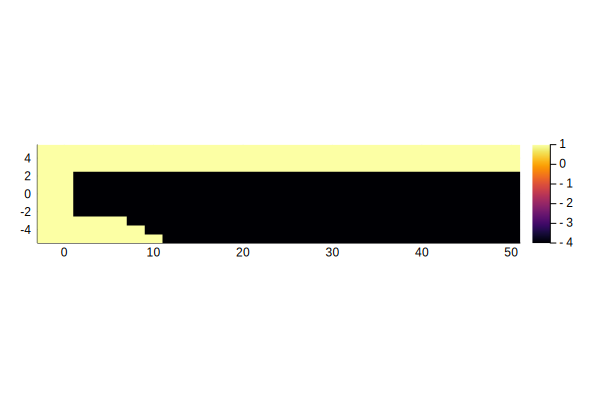

In [10]:
using Interact
using Plots
gr()

policy_grid = zeros(Float64, length(pomdp.T_RANGE), length(pomdp.S_RANGE))


#@manipulate for ego_v in pomdp.EGO_V_RANGE
    ego_v = 9.0
    #@manipulate for ped_v in pomdp.PED_V_RANGE
    ped_v = 0.0
        for i=1:length(pomdp.T_RANGE)
            ped_t = pomdp.T_RANGE[i]
            for j=1:length(pomdp.S_RANGE)
                ped_s = pomdp.S_RANGE[j]
                b = SparseCat([SingleOCFState(0.0, ego_v, ped_s, ped_t, 1.57, ped_v)],[1.])
                act = action(qmdp_policy, b) 
               # println(ped_s, "/", ped_t, " act: ", act.acc)
                policy_grid[i,j] = act.acc
            end
        end
        xs = [pomdp.S_RANGE[i] for i = 1:length(pomdp.S_RANGE)]
        ys = [pomdp.T_RANGE[i] for i = 1:length(pomdp.T_RANGE)]
        heatmap(xs,ys,policy_grid,aspect_ratio=1)
#    end
#end




In [49]:
using Interact
using Plots
gr()

policy_grid = zeros(Float64, length(pomdp.T_RANGE), length(pomdp.S_RANGE))

@manipulate for ego_v in pomdp.EGO_V_RANGE
    @manipulate for ped_v in pomdp.PED_V_RANGE

        for i=1:length(pomdp.T_RANGE)
            ped_t = pomdp.T_RANGE[i]
            for j=1:length(pomdp.S_RANGE)
                ped_s = pomdp.S_RANGE[j]
                b = SparseCat([SingleOCFState(0.0, ego_v, ped_s, ped_t, 1.57, ped_v)],[1.])
                act = action(qmdp_policy, b) 
              #  println(ped_s, "/", ped_t, " act: ", act.acc)
                policy_grid[i,j] = act.lateral_movement
            end
        end

        xs = [pomdp.S_RANGE[i] for i = 1:length(pomdp.S_RANGE)]
        ys = [pomdp.T_RANGE[i] for i = 1:length(pomdp.T_RANGE)]
        heatmap(xs,ys,policy_grid,aspect_ratio=1)
    end
end


Widget{:manipulate,Any}(OrderedDict{Symbol,Any}(:ego_v=>Widget{:slider,Float64}(OrderedDict{Symbol,Any}(:changes=>Observable{Int64} with 1 listeners. Value:
0,:index=>Observable{Any} with 2 listeners. Value:
8,:formatted_vals=>Observable{Any} with 1 listeners. Value:
["0.0", "1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0", "8.0", "9.0", "10.0", "11.0", "12.0", "13.0", "14.0"],:formatted_value=>Observable{String} with 1 listeners. Value:
"7.0",:value=>Observable{Float64} with 2 listeners. Value:
7.0), Observable{Float64} with 2 listeners. Value:
7.0, Scope("knockout-component-4dcfab5a-8511-4fcd-9ac6-a6a20985b524", Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :label), Any["ego_v"], Dict{Symbol,Any}(:className=>"interact ",:style=>Dict{Any,Any}(:padding=>"5px 10px 0px 10px")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"text-align:right;width:18%")), 2), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :input), Any[], Dict{Symbol,Any}(:max=>15,:min=>1,:attributes=>Dict{Any,Any}(:type=>"range",Symbol("data-bind")=>"numericValue: index, valueUpdate: 'input', event: {change : function () {this.changes(this.changes()+1)}}","orient"=>"horizontal"),:step=>1,:className=>"slider slider is-fullwidth",:style=>Dict{Any,Any}()), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"flex-grow:1; margin: 0 2%")), 1), Node{DOM}(DOM(:html, :div), Any[Node{DOM}(DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes=>Dict("data-bind"=>"text: formatted_value")), 0)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"width:18%")), 1)], Dict{Symbol,Any}(:attributes=>Dict("style"=>"display:flex; justify-content:center; align-items:center;")), 7), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("formatted_vals"=>(Observable{Any} with 1 listeners. Value:
["0.0", "1.0", "2.0", "3.0", "4.0", "5.0", "6.0", "7.0", "8.0", "9.0", "10.0", "11.0", "12.0", "13.0", "14.0"], nothing),"changes"=>(Observable{Int64} with 1 listeners. Value:
0, nothing),"formatted_value"=>(Observable{String} with 1 listeners. Value:
"7.0", nothing),"index"=>(Observable{Any} with 2 listeners. Value:
8, nothing)), Set(String[]), nothing, Any["knockout"=>"/home/xubuntu/.julia/packages/Knockout/JIqpG/src/../assets/knockout.js", "knockout_punches"=>"/home/xubuntu/.julia/packages/Knockout/JIqpG/src/../assets/knockout_punches.js", "/home/xubuntu/.julia/packages/InteractBase/Q4IkI/src/../assets/all.js", "/home/xubuntu/.julia/packages/InteractBase/Q4IkI/src/../assets/style.css", "/home/xubuntu/.julia/packages/InteractBulma/Ohu5Y/src/../assets/main.css"], Dict{Any,Any}("formatted_vals"=>Any[JSString("(function (val){return (val!=this.model[\"formatted_vals\"]()) ? (this.valueFromJulia[\"formatted_vals\"]=true, this.model[\"formatted_vals\"](val)) : undefined})")],"_promises"=>Dict{Any,Any}("importsLoaded"=>Any[JSString("function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init : function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            })\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            })\n            ko.applyBindingsToNode(element, { value: stringified, valueUpdate: allBindings.get('valueUpdate')}, context);\n        }\n    };\n    var json_data = JSON.parse(\"{\\\"formatted_vals\\\":[\\\"0.0\\\",\\\"1.0\\\",\\\"2.0\\\",\\\"3.0\\\",\\\"4.0\\\",\\\"5.0\\\",\\\"6.0\\\",\\\"7.0\\\",\\\"8.0\\\"

In [50]:
# Test action space


cnt = 0
for (index, a) in enumerate(pomdp.action_space)
    idx = actionindex(pomdp,a)
    if (idx != index)
        println("error")
        cnt = cnt + 1
    end
    println(a)
end
println(cnt)


[1.0, 1.0]
[0.0, 1.0]
[-1.0, 1.0]
[-2.0, 1.0]
[-4.0, 1.0]
[1.0, 0.0]
[0.0, 0.0]
[-1.0, 0.0]
[-2.0, 0.0]
[-4.0, 0.0]
[1.0, -1.0]
[0.0, -1.0]
[-1.0, -1.0]
[-2.0, -1.0]
[-4.0, -1.0]
0


In [12]:
state_space = states(pomdp)

state_space[stateindex(pomdp,SingleOCFState(0.5, 7.0, 2.0, 0.0, 1.57, 0.5))]

6-element SingleOCFState:
 0.5 
 7.0 
 2.0 
 0.0 
 1.57
 0.5 

In [9]:
using PedestrianAvoidancePOMDP

pomdp = SingleOCFPOMDP()

s = SingleOCFState(0.0, 11, 20.0, 0.0, 1.57, 1.5)
sp = SingleOCFState(0.0, 12, -6.0, 0.0, 0.0, 1.5)
act = SingleOCFAction(0.0, 1.0)
print("reward: ", reward(pomdp, s, act, sp))

b = SparseCat([sp],[1.])
act = action(qmdp_policy, b) 


VehicleDef(CAR, 4.000, 1.800)
VehicleDef(PEDESTRIAN, 3.000, 3.000)
VecSE2({-2.000, 0.000}, 0.000)
VecSE2({-6.000, 0.000}, 0.000)
reward: 0.0

2-element SingleOCFAction:
 1.0
 0.0

In [25]:
function POMDPs.reward(pomdp::SingleOCFPOMDP, s::SingleOCFState, action::SingleOCFAction, sp::SingleOCFState) 
    
    r = 0.

    # is there a collision?
    if collision_checker(pomdp,sp)
        r += pomdp.collision_cost
    end
    
    # is the goal reached?
    if sp.ped_s == 0
        r += pomdp.goal_reward
    end
    
    # keep velocity
    if (action.acc > 0.0 && sp.ego_v > pomdp.desired_velocity )
        r += (-3)
    end
   

#=
    # do not leave lane
    if (action.lateral_movement >= 0.1 && sp.ego_y >= pomdp.EGO_Y_MAX )
        r += (-5)
    end

    if (action.lateral_movement <= -.1 && sp.ego_y <= pomdp.EGO_Y_MIN )
        r += (-5)
    end
    

   # stay in center of the road
    r_lane = (10) * abs(1-s.ego_y)
    r += r_lane

 =#
    # keep velocity
 #   if (action.acc > 0.0)
  #    r_vel = (1) * ( -abs(pomdp.desired_velocity-sp.ego_v))
  #  if ( sp.ego_v > pomdp.desired_velocity)
  #      r_vel = 0.
  #  end

   #   r += r_vel
   # end

    
 #   if ( abs(pomdp.desired_velocity-sp.ego_v) < 1. )
 #       r += 20
 #   end

#=
    # costs for longitudinal actions
    if action.acc > 0. ||  action.acc < 0.0
        r += pomdp.action_cost_lon * abs(action.acc)*2
    end
        
    # costs for lateral actions
    if abs(action.lateral_movement) > 0 
        r += pomdp.action_cost_lat * abs(action.lateral_movement) 
    end

=#

#=
    if abs(action.acc) > 0 && abs(action.lateral_movement) > 0
        r += (-10)
    end
=#
  
   # println("velocity: ", r_vel ) 
   # println("lane: ", r_lane)

    return r
    
end


In [17]:

b = SparseCat([SingleOCFState(0.0, 14.0, 50.0, 5.0, 0., 0.)],[1.])
act = action(qmdp_policy, b) 
act.acc

1.0

In [9]:
pomdp


SingleOCFPOMDP
  env: CrosswalkEnv
  PED_SAFETY_DISTANCE: Float64 1.0
  ego_type: VehicleDef
  ped_type: VehicleDef
  longitudinal_actions: Array{Float64}((5,)) [1.0, 0.0, -1.0, -2.0, -4.0]
  lateral_actions: Array{Float64}((1,)) [0.0]
  ΔT: Float64 0.2
  PED_A_RANGE: Array{Float64}((3,)) [-1.0, 0.0, 1.0]
  PED_THETA_NOISE: Array{Float64}((3,)) [-0.195, 0.0, 0.195]
  EGO_Y_MIN: Float64 -1.0
  EGO_Y_MAX: Float64 1.0
  EGO_Y_RANGE: Array{Float64}((5,)) [-1.0, -0.5, 0.0, 0.5, 1.0]
  EGO_V_MIN: Float64 0.0
  EGO_V_MAX: Float64 14.0
  EGO_V_RANGE: Array{Float64}((15,)) [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 11.0, 12.0, 13.0, 14.0]
  S_MIN: Float64 -2.0
  S_MAX: Float64 50.0
  S_RANGE: Array{Float64}((27,)) [-2.0, 0.0, 2.0, 4.0, 6.0, 8.0, 10.0, 12.0, 14.0, 16.0  …  32.0, 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 46.0, 48.0, 50.0]
  T_MIN: Float64 -5.0
  T_MAX: Float64 5.0
  T_RANGE: Array{Float64}((11,)) [-5.0, -4.0, -3.0, -2.0, -1.0, 0.0, 1.0, 2.0, 3.0, 4.0, 5.0]
  PED_V_MIN: Fl

In [8]:
                b = SparseCat([SingleOCFState(0.0, 0., 0.0, 0.0, 1.57, 0.0)],[1.])
                act = action(qmdp_policy, b) 

2-element SingleOCFAction:
 1.0
 0.0

In [ ]:
                b = SparseCat([SingleOCFState(0.0, ego_v, ped_s, ped_t, 1.57, ped_v)],[1.])
                act = action(qmdp_policy, b) 